In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import auc,accuracy_score,precision_score,recall_score,classification_report,confusion_matrix,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids,TomekLinks,NeighbourhoodCleaningRule,NearMiss

def down_sampling(X,y,down_sampling_type,info):
    '''refer : https://towardsdatascience.com/sampling-techniques-for-extremely-imbalanced-data-part-i-under-sampling-a8dbc3d8d6d8'''
    
    #random under sampling
    if down_sampling_type == 'random':
        sampler = RandomUnderSampler(sampling_strategy = 15/85,random_state=0)
        X_ds, y_ds = sampler.fit_sample(X, y)
        if info:
            print('After random down sampling {}'.format(Counter(y_ds)))
        return X_ds,y_ds
    
    #nearmiss under sampling
    if down_sampling_type == 'nearmiss':
        sampler = NearMiss(sampling_strategy = 15/85)
        X_ds, y_ds = sampler.fit_sample(X, y)
        if info:
            print('After nearmiss down sampling {}'.format(Counter(y_ds)))        
    return X_ds,y_ds

#------------------------------------------------------------------------
    
def up_sampling(X,y,info):
    
    #up sampling
    sm = SMOTE(sampling_strategy = 30/70,random_state=0 )
    X_us, y_us = sm.fit_sample(X, y)
    if info:
        print('After SMOTE up sampling {}'.format(Counter(y_us)))
    return X_us,y_us

#------------------------------------------------------------------------
    
def re_sampling(X,y,info,sampling_type,down_sampling_type):
    
    if sampling_type=='none':
        if info:
            print('split as in original data {}'.format(Counter(y)))
        return X,y

    if sampling_type=='down_sampling':
        X_ds,y_ds = down_sampling(X,y,down_sampling_type=down_sampling_type,info=info)
        return X_ds,y_ds
    
    if sampling_type=='up_sampling':
        X_us,y_us = up_sampling(X,y,info=info)
        return X_us,y_us
    
    if sampling_type=='hybrid':
        X_ds,y_ds = down_sampling(X,y,down_sampling_type=down_sampling_type,info=info)
        X_hs,y_hs = up_sampling(X_ds,y_ds,info=info)
        return X_hs,y_hs

#----------------------------------------------------------------------------------

def train_test_resampled_split(X,y,info,sampling_type,down_sampling_type,test_size):  
    
    if info:
        print('Before sampling {}'.format(Counter(y)))
    X_rs,y_rs = re_sampling(X,y,info=info,sampling_type=sampling_type,down_sampling_type=down_sampling_type)
    
    
    
    X_train,X_test,y_train,y_test = train_test_split(X_rs,y_rs,test_size=test_size,random_state=0,stratify=y_rs)
    
    print('-'*50)
    
    return X_train,X_test,y_train,y_test

#----------------------------------------------------------------------------------

def cutoff_point(model,X,y,info,test_size,sampling_type,down_sampling_type,cv_search):

    X_train,X_test,y_train,y_test = train_test_resampled_split(X=X,y=y,info=info,test_size=test_size,sampling_type=sampling_type,down_sampling_type=down_sampling_type)
    
    if cv_search != True:
        model[1].fit(X_train, y_train)

    prd = model[1].predict(X_test)
    proba = model[1].predict_proba(X_test)
    
    y_pred_df = pd.DataFrame(proba)
    y_pred_1 = y_pred_df.iloc[:,1]
    y_test_df = pd.DataFrame(y_test)

    y_pred_1.reset_index(drop=True, inplace=True)
    y_test_df.reset_index(drop=True, inplace=True)

    y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
    y_pred_final= y_pred_final.rename(columns={ 0:'readmitted',1 : 'readmitted_probability'})
    y_pred_final['predicted'] = y_pred_final.readmitted_probability.map( lambda x: 1 if x > 0.5 else 0)
   

    numbers = [float(x)/100 for x in range(100)]
    for i in numbers:
        y_pred_final[i]= y_pred_final.readmitted_probability.map( lambda x: 1 if x > i else 0)
    y_pred_final.head()

    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensitivity','specificity','var_ssa','recall','precision','var_pra','Area Under Curve'])
    from sklearn.metrics import confusion_matrix
    
    for i in numbers:
        cm1 = confusion_matrix( y_pred_final.readmitted, y_pred_final[i] )
        total1=sum(sum(cm1))
        
        tp = cm1[0,0]
        tn = cm1[1,1]
        fp = cm1[1,0]
        fn = cm1[0,1]
        
        accuracy = (tp+tn)/total1
        
        sensi = tp/(tp+fn)
        speci = tn/(tn+fp)
        
        recall = tp/(tp+fn)
        precision = tp/(tp+fp)
        
        var_ssa = np.std([accuracy,sensi,speci])
        var_pra = np.std([accuracy,recall,precision])
        
        fpr, tpr, thresholds = roc_curve(y_pred_final.readmitted, y_pred_final[i])
        auc = metrics.auc(fpr, tpr)
        
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci,var_ssa,recall,precision,var_pra,auc]

    print('-'*50)
    print('Finding Optimal Cutoff Point based on accuracy, recall, precision')
    cutoff_df.plot.line(x='prob', y=['accuracy','recall','precision'])
    plt.show()
    optimum_pra = cutoff_df.iloc[cutoff_df['var_pra'].argmin()]
    print('Optimum cutoff probability is {0:.2f}'.format(optimum_pra[0]))
    
    optimum_accuracy = accuracy_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    optimum_precision = precision_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    optimum_recall = recall_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    optimum_roc_auc = roc_auc_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    
    print("Accuracy is {0:.2f}".format(optimum_accuracy))
    print("Precision is {0:.2f}".format(optimum_precision))
    print("Recall is {0:.2f}".format(optimum_recall))
    print("ROC_AUC Score is {0:.2f}".format(optimum_roc_auc))
    
    result_for_optimized.loc[model[0]+'_OC'] = [optimum_accuracy,optimum_precision,optimum_recall,optimum_roc_auc]
    
    print("\nClassification report\n",classification_report(y_pred_final.readmitted,y_pred_final[optimum_pra[0]]))
    print("confusion matrix \n\n", confusion_matrix(y_pred_final.readmitted,y_pred_final[optimum_pra[0]]))
    
    return cutoff_df

#----------------------------------------------------------------------------------

def plot_roc_curve(y_true,proba):
    fpr, tpr, threshold = roc_curve(y_true, proba)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#----------------------------------------------------------------------------------
    
def model_check(model,X,y,sampling_type,down_sampling_type,test_size=0.15,cv_search=False,info=False):
    
    print(model[0])
    print('-'*50)
    
    if cv_search :
        
        print('Data set Before resampling {}'.format(Counter(y)) if info else '')
        
        X_train,X_test,y_train,y_test, = train_test_resampled_split(X,y,test_size=test_size,sampling_type=sampling_type,down_sampling_type=down_sampling_type,info=info)
        
        print('Train set After resampling {}'.format(Counter(y_train)))
        print('Test set After resampling {}'.format(Counter(y_test)))
            
        model[1].fit(X_train, y_train)
        prd = model[1].predict(X_test)
        proba = model[1].predict_proba(X_test)[:,1]

        accuracy = accuracy_score(y_test, prd)
        precision = precision_score(y_test, prd)
        recall = recall_score(y_test, prd)
        roc_auc = roc_auc_score(y_test,proba)

        print("Accuracy is {0:.2f}".format(accuracy))
        print("Precision is {0:.2f}".format(precision))
        print("Recall is {0:.2f}".format(recall))
        print("ROC_AUC Score is {0:.2f}".format(roc_auc))
        plot_roc_curve(y_test,proba)
        print("\nClassification report\n",classification_report(y_test, prd))
        print("confusion matrix \n\n", confusion_matrix(y_test,prd)) 
        print('-'*50)
        print('best_parameters')
        print(model[1].best_params_)
        
        result.loc[model[0]] = [accuracy,precision,recall,roc_auc]

        
    else : 
    
        kf = model_selection.StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
        i=1
        cv_results=[]
        cv_df = pd.DataFrame( columns = ['kfold','accuracy','recall','precision','ROC_AUC'])
        for train_index,test_index in kf.split(X,y):
            print('{} of KFold {}'.format(i,kf.n_splits))

            xtr,xte = X.loc[train_index],X.loc[test_index]
            ytr,yte = y.loc[train_index],y.loc[test_index]

            X_tr_rs,y_tr_rs = re_sampling(xtr,ytr,info=info,sampling_type=sampling_type,down_sampling_type=down_sampling_type)

            X_te_rs,y_te_rs = re_sampling(xte,yte,info=info,sampling_type=sampling_type,down_sampling_type=down_sampling_type)

            model[1].fit(X_tr_rs, y_tr_rs)
            y_pred = model[1].predict(X_te_rs)
            y_proba = model[1].predict_proba(X_te_rs)[:,1]

            accuracy = accuracy_score(y_te_rs, y_pred)
            precision = precision_score(y_te_rs, y_pred)
            recall = recall_score(y_te_rs, y_pred)
            roc_auc = roc_auc_score(y_te_rs,y_proba)
            
            cv_df.loc[i] =[ i ,accuracy,recall,precision,roc_auc]
            '''print("\nAccuracy is {0:.2f}".format(accuracy))
            print("Precision is {0:.2f}".format(precision))
            print("Recall is {0:.2f}".format(recall))
            print("ROC_AUC Score is {0:.2f}".format(roc_auc))

            plot_roc_curve(y_te_rs,y_proba)

            print("\nClassification report\n",classification_report(y_te_rs, y_pred))
            print("confusion matrix \n\n", confusion_matrix(y_te_rs,y_pred))
            print('-'*50)'''

            i+=1    

        print('\n\n',cv_df)
        print('\nAverage accuracy after k-fold = {}'.format(np.mean(cv_df['accuracy'])))
        print('Average recall after k-fold = {}'.format(np.mean(cv_df['recall'])))
        print('Average precision after k-fold = {}'.format(np.mean(cv_df['precision'])))
        print('Average ROC_AUC after k-fold = {}'.format(np.mean(cv_df['ROC_AUC'])))
    
        result.loc[model[0]] = [np.mean(cv_df['accuracy']),np.mean(cv_df['precision']),np.mean(cv_df['recall']),np.mean(cv_df['ROC_AUC'])]
    
    print('-'*50)
    print('\n')
    cutoff_df = cutoff_point(model,X,y,cv_search=cv_search,info=info,test_size=test_size,sampling_type=sampling_type,down_sampling_type=down_sampling_type)

    return 

result = pd.DataFrame(columns=['Accuracy','Precision','Recall','AUC_ROC'])
result_for_optimized = pd.DataFrame(columns=['Accuracy','Precision','Recall','AUC_ROC'])

In [2]:
data = pd.read_csv('final_data.csv')
X = data.drop('readmitted',axis=1)
y = data['readmitted']

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

from sklearn.neighbors import KNeighborsClassifier

In [4]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from scipy.stats import uniform

In [5]:
from sklearn.preprocessing import StandardScaler

sc=StandardScaler()
X_std=sc.fit_transform(X)

In [6]:
X_stsc=pd.DataFrame(X_std,columns = X.columns)

K-Nearest Neighbor Classifier
--------------------------------------------------
1 of KFold 10
2 of KFold 10
3 of KFold 10
4 of KFold 10
5 of KFold 10
6 of KFold 10
7 of KFold 10
8 of KFold 10
9 of KFold 10
10 of KFold 10


     kfold  accuracy    recall  precision   ROC_AUC
1     1.0  0.718326  0.370007   0.544841  0.679680
2     2.0  0.725594  0.341847   0.571116  0.686949
3     3.0  0.719106  0.344016   0.550785  0.668872
4     4.0  0.726167  0.365598   0.567513  0.676136
5     5.0  0.718713  0.342708   0.549843  0.678762
6     6.0  0.722451  0.392272   0.552583  0.692565
7     7.0  0.725594  0.373936   0.564229  0.695846
8     8.0  0.733255  0.383759   0.584247  0.696251
9     9.0  0.711844  0.323510   0.532328  0.677559
10   10.0  0.716559  0.359528   0.541420  0.675118

Average accuracy after k-fold = 0.7217609919242249
Average recall after k-fold = 0.359718097998829
Average precision after k-fold = 0.5558904731511835
Average ROC_AUC after k-fold = 0.6827738813388586
------------

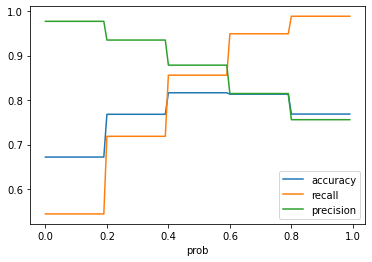

Optimum cutoff probability is 0.40
Accuracy is 0.82
Precision is 0.68
Recall is 0.72
ROC_AUC Score is 0.79

Classification report
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      5349
           1       0.68      0.72      0.70      2293

    accuracy                           0.82      7642
   macro avg       0.78      0.79      0.79      7642
weighted avg       0.82      0.82      0.82      7642

confusion matrix 

 [[4579  770]
 [ 633 1660]]


In [7]:
from sklearn.neighbors import KNeighborsClassifier
knn = ['K-Nearest Neighbor Classifier',KNeighborsClassifier()]
model_check(knn,X_stsc,y,sampling_type='hybrid',down_sampling_type='nearmiss',cv_search=False,info=False)

Knn with Randomsearch CV
--------------------------------------------------

--------------------------------------------------
Train set After resampling Counter({0: 28528, 1: 12225})
Test set After resampling Counter({0: 7132, 1: 3057})
Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 47.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 63.7min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed: 82.6min finished


Accuracy is 0.76
Precision is 0.57
Recall is 0.84
ROC_AUC Score is 0.88


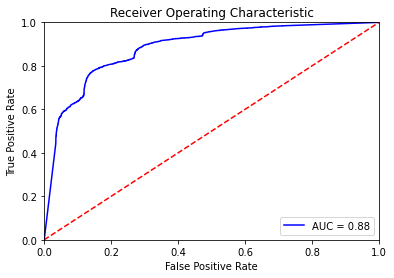


Classification report
               precision    recall  f1-score   support

           0       0.91      0.73      0.81      7132
           1       0.57      0.84      0.68      3057

    accuracy                           0.76     10189
   macro avg       0.74      0.79      0.75     10189
weighted avg       0.81      0.76      0.77     10189

confusion matrix 

 [[5217 1915]
 [ 487 2570]]
--------------------------------------------------
best_parameters
{'weights': 'distance', 'n_neighbors': 5}
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------
Finding Optimal Cutoff Point based on accuracy, recall, precision


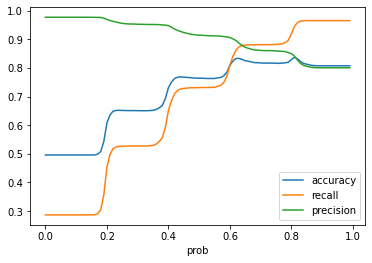

Optimum cutoff probability is 0.63
Accuracy is 0.83
Precision is 0.72
Recall is 0.74
ROC_AUC Score is 0.81

Classification report
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      7132
           1       0.72      0.74      0.73      3057

    accuracy                           0.83     10189
   macro avg       0.80      0.81      0.80     10189
weighted avg       0.83      0.83      0.83     10189

confusion matrix 

 [[6233  899]
 [ 800 2257]]


In [8]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

params = {'n_neighbors':np.arange(0,200),'weights':['uniform','distance']}
#knn=KNeighborsClassifier()
knn_rcv = ['Knn with Randomsearch CV',RandomizedSearchCV(knn[1], params, random_state=1, n_iter=1000, cv=10, verbose=1, n_jobs=-1,scoring = "roc_auc")]
model_check(knn_rcv,X,y,test_size=0.20,sampling_type='hybrid',down_sampling_type='nearmiss',cv_search=True,info=False)

In [9]:
result

,Accuracy,Precision,Recall,AUC_ROC
K-Nearest Neighbor Classifier,0.721761,0.555890,0.359718,0.682774
Knn with Randomsearch CV,0.764256,0.573021,0.840693,0.882952


In [10]:
result_for_optimized

,Accuracy,Precision,Recall,AUC_ROC
K-Nearest Neighbor Classifier_OC,0.816409,0.683128,0.723942,0.789995
Knn with Randomsearch CV_OC,0.833252,0.715146,0.738306,0.806127


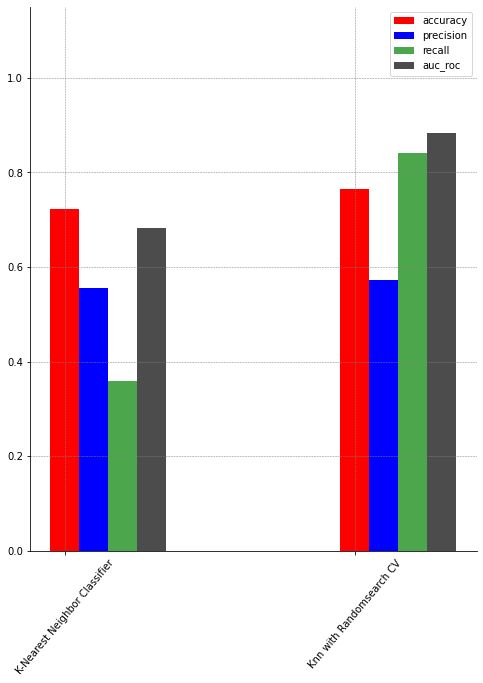

In [11]:
plt.figure(figsize=(8, 10))

ax = plt.subplot(111)

models = result.index
values = list(result['Accuracy'])
model = np.arange(len(result))

plt.bar(model, values, align='center', width = 0.1, color = 'red', label= 'accuracy')
#----------------
ax = plt.subplot(111)

models = result.index
values = list(result['Precision'])
model = np.arange(len(result))

plt.bar(model+0.1, values, align='center', width = 0.1, color = 'blue', label= 'precision')
#----------------
ax = plt.subplot(111)

models = result.index
values = list(result['Recall'])
model = np.arange(len(result))

plt.bar(model+0.2, values, align='center', width = 0.1, alpha=0.7, color = 'Green', label= 'recall')
#----------------
ax = plt.subplot(111)

models = result.index
values = list(result['AUC_ROC'])
model = np.arange(len(result))

plt.bar(model+0.3, values, align='center', width = 0.1, alpha=0.7, color = 'black', label= 'auc_roc')
plt.xticks(model, models,rotation=50,size=10)
plt.yticks(size=10)
ax.set_ylim(top=1.15)
#----------------
ax = plt.subplot(111)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc = 1,prop={'size': 10})
ax.grid(which='major',linestyle='--', linewidth='0.5', color='grey')

plt.show() 

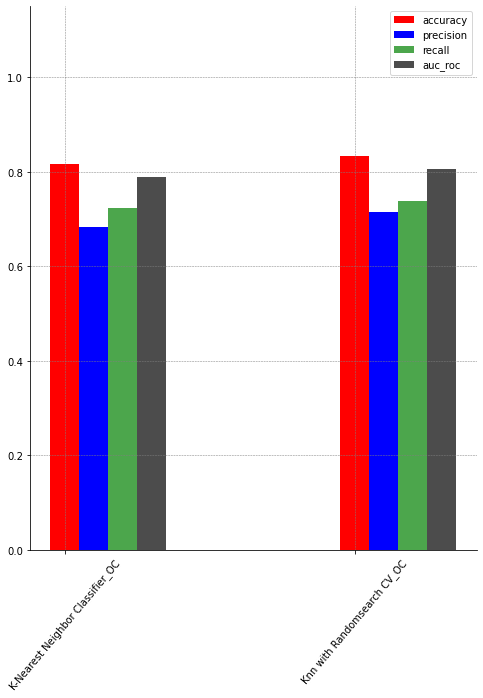

In [12]:
plt.figure(figsize=(8, 10))

ax = plt.subplot(111)

models = result_for_optimized.index
values = list(result_for_optimized['Accuracy'])
model = np.arange(len(result_for_optimized))

plt.bar(model, values, align='center', width = 0.1, color = 'red', label= 'accuracy')
#----------------
ax = plt.subplot(111)

models = result_for_optimized.index
values = list(result_for_optimized['Precision'])
model = np.arange(len(result_for_optimized))

plt.bar(model+0.1, values, align='center', width = 0.1, color = 'blue', label= 'precision')
#----------------
ax = plt.subplot(111)

models = result_for_optimized.index
values = list(result_for_optimized['Recall'])
model = np.arange(len(result_for_optimized))

plt.bar(model+0.2, values, align='center', width = 0.1, alpha=0.7, color = 'Green', label= 'recall')
#----------------
ax = plt.subplot(111)

models = result_for_optimized.index
values = list(result_for_optimized['AUC_ROC'])
model = np.arange(len(result_for_optimized))

plt.bar(model+0.3, values, align='center', width = 0.1, alpha=0.7, color = 'black', label= 'auc_roc')
plt.xticks(model, models,rotation=50,size=10)
plt.yticks(size=10)
ax.set_ylim(top=1.15)
#----------------
ax = plt.subplot(111)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc = 1,prop={'size': 10})
ax.grid(which='major',linestyle='--', linewidth='0.5', color='grey')

plt.show() 

In [13]:
fin_res = pd.concat([result,result_for_optimized],axis=0)
fin_res.to_csv('fin_res_knn.csv')
fin_res

,Accuracy,Precision,Recall,AUC_ROC
K-Nearest Neighbor Classifier,0.721761,0.555890,0.359718,0.682774
Knn with Randomsearch CV,0.764256,0.573021,0.840693,0.882952
K-Nearest Neighbor Classifier_OC,0.816409,0.683128,0.723942,0.789995
Knn with Randomsearch CV_OC,0.833252,0.715146,0.738306,0.806127
